
The first step towards tackling these issues is perhaps to create a general AI tool to help pathlogoists segment and count cells within a sample slide.

In this notebook, We demonstrate such a cell segmentation tool by training a deep convolutional neural network on cell images acquired from the  [2018 Science Bowl Kaggle competition](https://www.kaggle.com/c/data-science-bowl-2018) (data available after registration). Specifically, training was performed on 670 labeled images using a U-Net architecture [1], with a 90/10 train/validation split, testing was done on an additional 65 images. This dataset is particularly useful as it includes different kinds of images with varying sizes, colours, modalities. Thus, the network learns to segment cells across different conditions without handcraftining features. The network was implemented using Keras and Tensorflow. Additionally, I created a simple function to count the number of cells after segmentation.

Overall the model does a good job at segmenting images and counting cells. Future development will focus on classification and counting of different cell types. 

This notebook includes the following sections:
<ol>
<li> Import required libraries</li> 
<li>Load datasets</li>
<li>Image preprocessing</li>
<li>Data Visualization</li>
<li>Setup U-net model</li>
<li>Training</li>
<li>Prediction</li>
<li>Visualize Results</li>
<li>Cell Counting</li>
</ol>

[1] Janowczyk, A., & Madabhushi, A. (2016). Deep learning for digital pathology image analysis: A comprehensive tutorial with selected use cases. Journal of pathology informatics, 7.

[2] Litjens, G., Kooi, T., Bejnordi, B. E., Setio, A. A. A., Ciompi, F., Ghafoorian, M., ... & Sánchez, C. I. (2017). A survey on deep learning in medical image analysis. Medical image analysis, 42, 60-88.

## 1) Import required libraries

In [ ]:
%matplotlib inline
import os
import random
import sys
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from PIL import Image
import cv2
import h5py
from help_functions import *
#from skimage.color import rgb2gray

import tensorflow as tf

from keras.utils import Progbar
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose,Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

# Setting seed for reproducibility
seed = 41
random.seed = seed
np.random.seed = seed
smooth = 1.
epochs = 50

## 2) Load datasets

Here we'll try two file formats hdf5 and numpy arrays. 

### First lets try hfd5:

In [ ]:
# Data Path
TRAIN_PATH = '../Nuclei/stage1_train/'
TEST_PATH = '../Nuclei/stage1_test/'
dataset_path = 'datasets_hdf5/'


In [ ]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]
print(len(test_ids))

65


In [ ]:
# Get data in hdf5 format if available or convert original images to hdf5 format.

Nimgs=len(train_ids)
N_test_imgs=len(test_ids)
IMG_WIDTH=256
IMG_HEIGHT=256
IMG_CHANNELS=3

def write_hdf5(arr,outfile):
  with h5py.File(outfile,"w") as f:
    f.create_dataset("image", data=arr, dtype=arr.dtype)
    
def load_hdf5(infile):
  with h5py.File(infile,"r") as f:  #"with" close the file after its nested commands
    return f["image"][()]
    
def get_train_dataset(train_img_hdf5_file, train_mask_hdf5_file):
    imgs = np.zeros((Nimgs,IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS))
    groundTruth = np.zeros((Nimgs,IMG_HEIGHT,IMG_WIDTH,1))
    # load from hdf5 if it exists
    if os.path.isfile(dataset_path+train_img_hdf5_file) and os.path.isfile(dataset_path+train_mask_hdf5_file):
        print("Train dataset found and loaded from memory.")
        imgs = load_hdf5(dataset_path+train_img_hdf5_file)
        groundTruth = load_hdf5(dataset_path+train_mask_hdf5_file)
        return imgs, groundTruth
    a = Progbar(len(train_ids))
    # if hdf5 doesn't exist then load original images and create hdf5
    print("hdf5 files not found, creating hdf5 from original dataset...")
    for n, id_ in enumerate(train_ids):
        path = TRAIN_PATH + id_
        img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        imgs[n] = np.asarray(img)
        #print('img.shape=',img.shape)
        #print('imgs.shape=',imgs.shape)
        
        # create merged mask     
        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
        for mask_file in next(os.walk(path + '/masks/'))[2]:
            mask_ = imread(path + '/masks/' + mask_file)
            mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                        preserve_range=True), axis=-1)
            mask = np.maximum(mask, mask_)
        groundTruth[n] = np.asarray(mask)
        a.update(n)
        ###

    print "imgs max: " +str(np.max(imgs))
    print "imgs min: " +str(np.min(imgs))
    assert(np.max(groundTruth)==255)
    assert(np.min(groundTruth)==0)
    print "Masks are correctly within pixel value range 0-255 (black-white)"
    #reshaping for my standard tensors
    imgs = np.transpose(imgs,(0,3,1,2))
    assert(imgs.shape == (Nimgs,IMG_CHANNELS,IMG_HEIGHT,IMG_WIDTH))
    groundTruth = np.reshape(groundTruth,(Nimgs,1,IMG_HEIGHT,IMG_WIDTH))
    assert(groundTruth.shape == (Nimgs,1,IMG_HEIGHT,IMG_WIDTH))
    write_hdf5(imgs, dataset_path + train_img_hdf5_file)
    write_hdf5(groundTruth, dataset_path + train_mask_hdf5_file)
    return imgs, groundTruth

def get_test_dataset(test_img_hdf5_file):
    imgs = np.zeros((N_test_imgs,IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS))
    # load from hdf5 if it exists
    if os.path.isfile(dataset_path+test_img_hdf5_file):
        print("Test dataset found and loaded from memory.")
        imgs = load_hdf5(dataset_path+test_img_hdf5_file)
        return imgs
    a = Progbar(len(test_ids))
    # if hdf5 doesn't exist then load original images and create hdf5
    print("hdf5 test files not found, creating hdf5 from original dataset...")
    for n, id_ in enumerate(test_ids):
        path = TEST_PATH + id_
        img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        imgs[n] = np.asarray(img)
        a.update(n)
        ###
    print "imgs max: " +str(np.max(imgs))
    print "imgs min: " +str(np.min(imgs))
    #reshaping for my standard tensors
    imgs = np.transpose(imgs,(0,3,1,2))
    assert(imgs.shape == (N_test_imgs,IMG_CHANNELS,IMG_HEIGHT,IMG_WIDTH))
    write_hdf5(imgs, dataset_path + test_img_hdf5_file)
    return imgs


In [ ]:
# Get hdf5 datasets
train_img_hdf5_file="Nuclei_dataset_imgs_train.hdf5"
train_mask_hdf5_file="Nuclei_dataset_masks_train.hdf5"
test_img_hdf5_file="Nuclei_dataset_imgs_test.hdf5"
hdf5_imgs_train, hdf5_train_masks = get_train_dataset(train_img_hdf5_file, train_mask_hdf5_file)
hdf5_imgs_test = get_test_dataset(test_img_hdf5_file)

Train dataset found and loaded from memory.
Test dataset found and loaded from memory.


In [ ]:
print(hdf5_imgs_train.shape)
print(hdf5_imgs_test.shape)
print(hdf5_train_masks.shape)


(670, 3, 256, 256)
(65, 3, 256, 256)
(670, 1, 256, 256)


### Now let's try the numpy array format:

In [ ]:
# Read train images and masks return as numpy array
def read_train_data(IMG_WIDTH=256,IMG_HEIGHT=256,IMG_CHANNELS=3):
    X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    print('Getting and resizing train images and masks ... ')
    sys.stdout.flush()
    if os.path.isfile("train_img.npy") and os.path.isfile("train_mask.npy"):
        print("Train file loaded from memory")
        X_train = np.load("train_img.npy")
        Y_train = np.load("train_mask.npy")
        return X_train,Y_train
    a = Progbar(len(train_ids))
    for n, id_ in enumerate(train_ids):
        path = TRAIN_PATH + id_
        img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_train[n] = img
        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
        for mask_file in next(os.walk(path + '/masks/'))[2]:
            mask_ = imread(path + '/masks/' + mask_file)
            mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                        preserve_range=True), axis=-1)
            mask = np.maximum(mask, mask_)
        Y_train[n] = mask
        a.update(n)
    np.save("train_img",X_train)
    np.save("train_mask",Y_train)
    return X_train,Y_train

In [ ]:
# Read test images and return as numpy array
def read_test_data(IMG_WIDTH=256,IMG_HEIGHT=256,IMG_CHANNELS=3):
    X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    sizes_test = []
    print('\nGetting and resizing test images ... ')
    sys.stdout.flush()
    if os.path.isfile("test_img.npy") and os.path.isfile("test_size.npy"):
        print("Test file loaded from memory")
        X_test = np.load("test_img.npy")
        sizes_test = np.load("test_size.npy")
        return X_test,sizes_test
    b = Progbar(len(test_ids))
    for n, id_ in enumerate(test_ids):
        path = TEST_PATH + id_
        img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
        sizes_test.append([img.shape[0], img.shape[1]])
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_test[n] = img
        b.update(n)
    np.save("test_img",X_test)
    np.save("test_size",sizes_test)
    return X_test,sizes_test

In [ ]:
## Read data from numpy array
# get train_data
train_imgs,train_masks = read_train_data()

# get test_data
test_imgs,test_img_sizes = read_test_data()

Getting and resizing train images and masks ... 
Train file loaded from memory

Getting and resizing test images ... 
Test file loaded from memory


## 3) Image preprocessing


In [ ]:
# Image Preprocessing

def my_PreProc(data):
    assert(len(data.shape)==4)
    assert (data.shape[1]==3)  #Use the original images
    #black-white conversion
    #imgs = rgb2gray(data)
    #my preprocessing:
    imgs = dataset_normalized(data)
    #imgs = clahe_equalized(imgs)
    imgs = adjust_gamma(imgs, 1.2)
    imgs = imgs/255.  #reduce to 0-1 range
    return imgs


#============================================================
#========= PRE PROCESSING FUNCTIONS ========================#
#============================================================

#==== histogram equalization
def histo_equalized(imgs):
    #assert (len(imgs.shape)==4)  #4D arrays
    #assert (imgs.shape[1]==1)  #check the channel is 1
    imgs_equalized = np.empty(imgs.shape)
    for i in range(imgs.shape[0]):
        imgs_equalized[i,0] = cv2.equalizeHist(np.array(imgs[i,0], dtype = np.uint8))
    return imgs_equalized


# CLAHE (Contrast Limited Adaptive Histogram Equalization)
#adaptive histogram equalization is used. In this, image is divided into small blocks called "tiles" (tileSize is 8x8 by default in OpenCV). Then each of these blocks are histogram equalized as usual. So in a small area, histogram would confine to a small region (unless there is noise). If noise is there, it will be amplified. To avoid this, contrast limiting is applied. If any histogram bin is above the specified contrast limit (by default 40 in OpenCV), those pixels are clipped and distributed uniformly to other bins before applying histogram equalization. After equalization, to remove artifacts in tile borders, bilinear interpolation is applied
def clahe_equalized(imgs):
    #assert (len(imgs.shape)==4)  #4D arrays
    #assert (imgs.shape[1]==1)  #check the channel is 1
    #create a CLAHE object (Arguments are optional).
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    imgs_equalized = np.empty(imgs.shape)
    for i in range(imgs.shape[0]):
        imgs_equalized[i,0] = clahe.apply(np.array(imgs[i,0], dtype = np.uint8))
    return imgs_equalized


# ===== normalize over the dataset
def dataset_normalized(imgs):
    #assert (len(imgs.shape)==4)  #4D arrays
    #assert (imgs.shape[1]==1)  #check the channel is 1
    imgs_normalized = np.empty(imgs.shape)
    imgs_std = np.std(imgs)
    imgs_mean = np.mean(imgs)
    imgs_normalized = (imgs-imgs_mean)/imgs_std
    for i in range(imgs.shape[0]):
        imgs_normalized[i] = ((imgs_normalized[i] - np.min(imgs_normalized[i])) / (np.max(imgs_normalized[i])-np.min(imgs_normalized[i])))*255
    return imgs_normalized


def adjust_gamma(imgs, gamma=1.0):
    #assert (len(imgs.shape)==4)  #4D arrays
    #assert (imgs.shape[1]==1)  #check the channel is 1
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    # apply gamma correction using the lookup table
    new_imgs = np.empty(imgs.shape)
    for i in range(imgs.shape[0]):
        new_imgs[i,0] = cv2.LUT(np.array(imgs[i,0], dtype = np.uint8), table)
    return new_imgs

#### Apply preprocessing to both hdf5 and numpy format images

In [ ]:
# Apply preprocessing to original images:
trans_train_imgs=np.transpose(train_imgs,(0,3,1,2)) # need to transpose it to get the right dims
preproc_imgs = my_PreProc(trans_train_imgs)
preproc_imgs=np.transpose(preproc_imgs,(0,2,3,1)) # need to transpose again it to get the right dims

trans_test_imgs=np.transpose(test_imgs,(0,3,1,2)) # need to transpose it to get the right dims
preproc_test_imgs = my_PreProc(trans_test_imgs)
preproc_test_imgs=np.transpose(preproc_test_imgs,(0,2,3,1)) # need to transpose again it to get the right dims

# apply preprocessing to hdf5 images
hdf5_preproc_imgs = my_PreProc(hdf5_imgs_train)
hdf5_preproc_imgs=np.transpose(hdf5_preproc_imgs,(0,2,3,1))
hdf5_masks=np.transpose(hdf5_train_masks,(0,2,3,1))


## 4) Data Visualization

Let's check that the data looks ok before we move on to the model.

In [ ]:
# Check if training data looks alright
ix = random.randint(0, len(train_ids))
print("Showing training image no:",ix)
mask_img = np.squeeze(train_masks[ix])
preproc_img = preproc_imgs[ix]

# Plot samples images
fig = plt.figure(figsize=(12, 12))
plt.subplot(131).set_title('Original')
plt.imshow(train_imgs[ix])
plt.subplot(132).set_title('Mask (Target)')
plt.imshow(mask_img)
plt.subplot(133).set_title('Preprocessed')
plt.imshow(preproc_img)
plt.show()

# Check hdf5 data

hdf5_img = np.transpose(hdf5_imgs_train,(0,2,3,1))[ix]
hdf5_floor_img = np.floor(hdf5_img)
hdf5_mask=np.squeeze(hdf5_masks[ix])
hdf5_preproc_img=hdf5_preproc_imgs[ix]


# Plot hdf5 samples images
fig = plt.figure(figsize=(12, 12))
plt.subplot(141).set_title('HDF5 Image')
plt.imshow(hdf5_img)
plt.subplot(142).set_title('HDF5 Floor')
plt.imshow(hdf5_floor_img)
plt.subplot(143).set_title('HDF5 Mask')
plt.imshow(hdf5_mask)
plt.subplot(144).set_title('HDF5 Preprocessed')
plt.imshow(hdf5_preproc_img)
plt.show()

# Check a random test image
x = random.randint(0, len(test_ids))
print('Show Random test image:',x)
plt.imshow(test_imgs[x]) 
plt.show()
print('Show Random test image:',x)
plt.imshow(preproc_test_imgs[x]) 
plt.show()


The data looks ok. Note the in hdf5 format resizing introduces noise which seems to be corrected later in the preprocessing steps.

## 5) Setup U-net model

First we'll setup potential metric functions to judge the performance of the model.

In [ ]:
# Metric function
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Loss funtion
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [ ]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2, y_true)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [ ]:
def iou_coef(y_true, y_pred, smooth=1):
    
    """
    IoU = (|X & Y|)/ (|X or Y|)
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f,-1) + K.sum(y_pred_f,-1) - intersection
    return (intersection + smooth) / ( union + smooth)

def iou_coef_loss(y_true, y_pred):
    return -iou_coef(y_true, y_pred)

### Here is the U-Net model implemented in Keras

U-net is a popular convolutional network architecture for fast and precise segmentation of images. It has received much praise for winning a number of competitions including the Grand Challenge for Computer-Automated Detection of Caries in Bitewing Radiography at ISBI 2015, and the Cell Tracking Challenge at ISBI 2015 on the two most challenging transmitted light microscopy categories (Phase contrast and DIC microscopy) by a large margin (See also our annoucement).

The architecture consists of a contracting path to capture context and a symmetric expanding path that enables precise localization. One important advantage of this architecture is that it it has shown very good performance with small sample sizes, as is the case with the data I use here.




Ronneberger, O., Fischer, P., & Brox, T. (2015, October). U-net: Convolutional networks for biomedical image segmentation. In International Conference on Medical image computing and computer-assisted intervention (pp. 234-241). Springer, Cham.

In [ ]:
def get_unet(IMG_WIDTH=256,IMG_HEIGHT=256,IMG_CHANNELS=3):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = Lambda(lambda x: x / 255) (inputs)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = Dropout(0.3) (c5)
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = Dropout(0.2) (c6)
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam',loss='binary_crossentropy', metrics=[iou_coef])
    return model

# 6) Training
### Now we're ready to train the model

We'll set early stopping with a patience of 10 in case we decide to use it later. So, if the validation loss doesn't improve after 10 epochs then the model stops. We also set checkpointer which saves the model weights everytime it sees an improvement. I picked a batch_size of 16 based on what my gpu memory allowed. 

In the end, I decided to run it for 100 epochs without early stopping. 

I ran this on a Titan X GPU with 12GB of memory, it takes about 5 minutes to run 50 epochs.

### WARNING: Training this model on a CPU is not recommended as it will take several hours or even days to complete. Instead, skip to section 7 and try loading the pre-trained weights privided.

In [ ]:
# get u_net model
model = get_unet()

### Try 2 runs

1. Train the a model on the numpy data without preproccessing.
2. Train the a model on the numpy data numpy data with prerpoccessing.


In [ ]:
# 1. Train model on numpy train_data without preprocessing
print("\nTraining model...")

earlystopper = EarlyStopping(patience=10, verbose=1)
checkpointer = ModelCheckpoint('model-1-dsbowl2018_iou_coef_e100b16.h5', verbose=1, save_best_only=True)
results = u_net.fit(train_imgs,train_masks, validation_split=0.1, batch_size=16, epochs=100, 
                    callbacks=[checkpointer])


Training model...
Train on 603 samples, validate on 67 samples
Epoch 1/100
592/603 [============================>.] - ETA: 0s - loss: 0.4057 - iou_coef: 0.1349
Epoch 00001: val_loss improved from inf to 0.20089, saving model to model-1-dsbowl2018_iou_coef_e100b16.h5
603/603 [==============================] - 16s 27ms/step - loss: 0.4030 - iou_coef: 0.1378 - val_loss: 0.2009 - val_iou_coef: 0.3883
Epoch 2/100
592/603 [============================>.] - ETA: 0s - loss: 0.1691 - iou_coef: 0.5140
Epoch 00002: val_loss improved from 0.20089 to 0.13603, saving model to model-1-dsbowl2018_iou_coef_e100b16.h5
603/603 [==============================] - 10s 16ms/step - loss: 0.1676 - iou_coef: 0.5166 - val_loss: 0.1360 - val_iou_coef: 0.6172
Epoch 3/100
592/603 [============================>.] - ETA: 0s - loss: 0.1260 - iou_coef: 0.6260
Epoch 00003: val_loss improved from 0.13603 to 0.10851, saving model to model-1-dsbowl2018_iou_coef_e100b16.h5
603/603 [==============================] - 10s 16m

Epoch 57/100
592/603 [============================>.] - ETA: 0s - loss: 0.0552 - iou_coef: 0.8041
Epoch 00057: val_loss did not improve
603/603 [==============================] - 9s 16ms/step - loss: 0.0553 - iou_coef: 0.8048 - val_loss: 0.0656 - val_iou_coef: 0.7651
Epoch 58/100
592/603 [============================>.] - ETA: 0s - loss: 0.0553 - iou_coef: 0.8072
Epoch 00058: val_loss did not improve
603/603 [==============================] - 9s 16ms/step - loss: 0.0549 - iou_coef: 0.8075 - val_loss: 0.0746 - val_iou_coef: 0.7799
Epoch 59/100
592/603 [============================>.] - ETA: 0s - loss: 0.0548 - iou_coef: 0.8069
Epoch 00059: val_loss did not improve
603/603 [==============================] - 10s 16ms/step - loss: 0.0546 - iou_coef: 0.8076 - val_loss: 0.0673 - val_iou_coef: 0.7685
Epoch 60/100
592/603 [============================>.] - ETA: 0s - loss: 0.0541 - iou_coef: 0.8098
Epoch 00060: val_loss did not improve
603/603 [==============================] - 9s 16ms/step - l

Epoch 88/100
592/603 [============================>.] - ETA: 0s - loss: 0.0485 - iou_coef: 0.8270
Epoch 00088: val_loss did not improve
603/603 [==============================] - 9s 15ms/step - loss: 0.0484 - iou_coef: 0.8276 - val_loss: 0.0715 - val_iou_coef: 0.7838
Epoch 89/100
592/603 [============================>.] - ETA: 0s - loss: 0.0415 - iou_coef: 0.8482
Epoch 00089: val_loss did not improve
603/603 [==============================] - 9s 15ms/step - loss: 0.0415 - iou_coef: 0.8489 - val_loss: 0.0791 - val_iou_coef: 0.7946
Epoch 90/100
592/603 [============================>.] - ETA: 0s - loss: 0.0385 - iou_coef: 0.8573
Epoch 00090: val_loss did not improve
603/603 [==============================] - 9s 15ms/step - loss: 0.0382 - iou_coef: 0.8575 - val_loss: 0.0851 - val_iou_coef: 0.7948
Epoch 91/100
592/603 [============================>.] - ETA: 0s - loss: 0.0363 - iou_coef: 0.8643
Epoch 00091: val_loss did not improve
603/603 [==============================] - 9s 15ms/step - lo

As expected, the training and validation loss decrease repidly at first but then slows down and the validation interection over union coefficient (val_iou_coef) settles around .80, which is not bad.

In [ ]:
# 2. Train model on numpy train_data with preprocessing
print("\nTraining...")

train_imgs,train_masks

earlystopper = EarlyStopping(patience=10, verbose=1)
checkpointer = ModelCheckpoint('model-2-dsbowl2018.h5', verbose=1, save_best_only=True)
results = u_net.fit(preproc_imgs,train_masks, validation_split=0.1, batch_size=8, epochs=50, 
                    callbacks=[checkpointer])


Training...
Train on 603 samples, validate on 67 samples
Epoch 1/50
600/603 [============================>.] - ETA: 0s - loss: 0.3979 - mean_iou: 8.1573e-04
Epoch 00001: val_loss improved from inf to 0.25061, saving model to model-2-dsbowl2018.h5
603/603 [==============================] - 13s 22ms/step - loss: 0.3980 - mean_iou: 8.2259e-04 - val_loss: 0.2506 - val_mean_iou: 0.0021
Epoch 2/50
600/603 [============================>.] - ETA: 0s - loss: 0.2148 - mean_iou: 0.0208
Epoch 00002: val_loss improved from 0.25061 to 0.19505, saving model to model-2-dsbowl2018.h5
603/603 [==============================] - 13s 21ms/step - loss: 0.2150 - mean_iou: 0.0210 - val_loss: 0.1950 - val_mean_iou: 0.0660
Epoch 3/50
600/603 [============================>.] - ETA: 0s - loss: 0.1741 - mean_iou: 0.1006
Epoch 00003: val_loss improved from 0.19505 to 0.14421, saving model to model-2-dsbowl2018.h5
603/603 [==============================] - 13s 21ms/step - loss: 0.1737 - mean_iou: 0.1007 - val_loss:

Epoch 29/50
600/603 [============================>.] - ETA: 0s - loss: 0.0949 - mean_iou: 0.2958
Epoch 00029: val_loss improved from 0.09585 to 0.09341, saving model to model-2-dsbowl2018.h5
603/603 [==============================] - 13s 22ms/step - loss: 0.0948 - mean_iou: 0.2958 - val_loss: 0.0934 - val_mean_iou: 0.2970
Epoch 30/50
600/603 [============================>.] - ETA: 0s - loss: 0.0970 - mean_iou: 0.2983
Epoch 00030: val_loss did not improve
603/603 [==============================] - 13s 21ms/step - loss: 0.0969 - mean_iou: 0.2983 - val_loss: 0.0950 - val_mean_iou: 0.2996
Epoch 31/50
600/603 [============================>.] - ETA: 0s - loss: 0.0953 - mean_iou: 0.3008
Epoch 00031: val_loss improved from 0.09341 to 0.09201, saving model to model-2-dsbowl2018.h5
603/603 [==============================] - 13s 22ms/step - loss: 0.0957 - mean_iou: 0.3008 - val_loss: 0.0920 - val_mean_iou: 0.3020
Epoch 32/50
600/603 [============================>.] - ETA: 0s - loss: 0.0933 - mean

## 7) Prediction (testing)

Performance did not differ much between the two trained models above, so we'll use the model trained on data without preprocessing.

#### Let's use the trainned model to predict on the test images. 

I'll also predict on the training and validation sets just for sanity check later.

In [ ]:
#del model
#del u_net

In [ ]:
print("Predicting")
## Predict on test data

TRAIN_DATA = train_imgs #preproc_imgs
TEST_DATA = test_imgs #train_masks #preproc_test_imgs

# Predict on train, val and test
#model = load_model('unet_simple_model_150epochs.h5', custom_objects={'dice_coef': dice_coef})
model.load_weights('unet_simple_model_150epochs_weights.h5')
preds_train = model.predict(TRAIN_DATA[:int(TRAIN_DATA.shape[0]*0.9)], verbose=1)
preds_val = model.predict(TRAIN_DATA[int(TRAIN_DATA.shape[0]*0.9):], verbose=1)
preds_test = model.predict(TEST_DATA, verbose=1)
preds_test = model.predict(TEST_DATA, verbose=1)


# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (test_img_sizes[i][0], test_img_sizes[i][1]), 
                                       mode='constant', preserve_range=True))

Predicting
65/65 [==============================] - 13s 200ms/step


In [ ]:
#model.save_weights('unet_simple_model_150epochs_weights.h5')

## 8) Visualize Results

Now that the model has successfully ran, let's take a look at the results.

#### Check that it does ok on the trainning data

('Trainning example No.', 139)


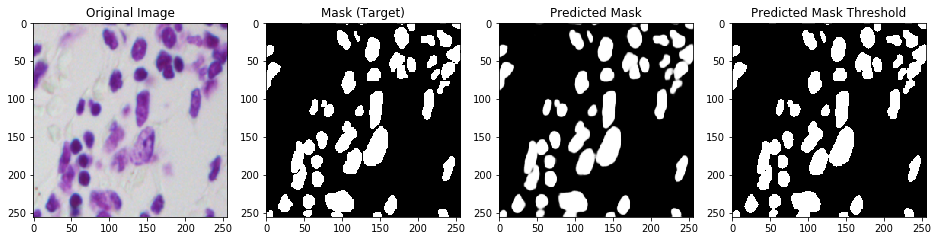

In [ ]:
# Perform a sanity check on some random training samples
ix = 139 # random.randint(0, len(preds_train_t)) # 138 nice large bw cells, 139 purple and white messy
print('Trainning example No.',ix)

hdf5_mask=np.squeeze(np.transpose(hdf5_train_masks,(0,2,3,1))[ix])

fig = plt.figure(figsize=(16, 16))
plt.subplot(141).set_title('Original Image')
plt.imshow(train_imgs[ix])
plt.subplot(142).set_title('Mask (Target)')
plt.imshow(np.squeeze(train_masks[ix]), cmap='gray')
plt.subplot(143).set_title('Predicted Mask')
plt.imshow(np.squeeze(preds_train[ix]),cmap='gray')
plt.subplot(144).set_title('Predicted Mask Threshold')
plt.imshow(np.squeeze(preds_train_t[ix]),cmap='gray')
plt.show()

### Check that it does ok on the validation data

('Random sample from validation set no.', 64)


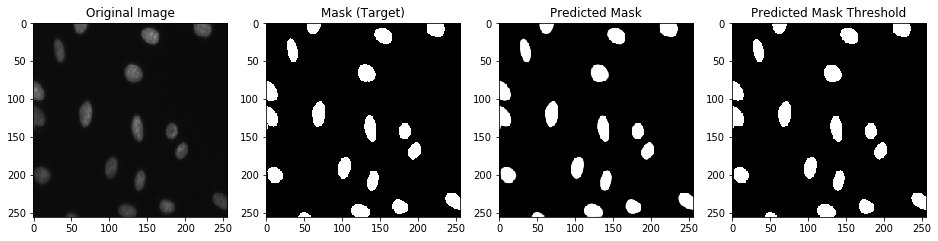

In [ ]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
print("Random sample from validation set no.",ix)
val_img=train_imgs[int(train_imgs.shape[0]*0.9):][ix]
val_mask=np.squeeze(train_masks[int(train_masks.shape[0]*0.9):][ix])

fig3 = plt.figure(figsize=(16, 16))
plt.subplot(141).set_title('Original Image')
plt.imshow(val_img)
plt.subplot(142).set_title('Mask (Target)')
plt.imshow(np.squeeze(val_mask), cmap='gray')
plt.subplot(143).set_title('Predicted Mask')
plt.imshow(np.squeeze(preds_val[ix]), cmap='gray')
plt.subplot(144).set_title('Predicted Mask Threshold')
plt.imshow(np.squeeze(preds_val_t[ix]), cmap='gray')
plt.show()

### Finally, let's check how it did on the test dataset

12


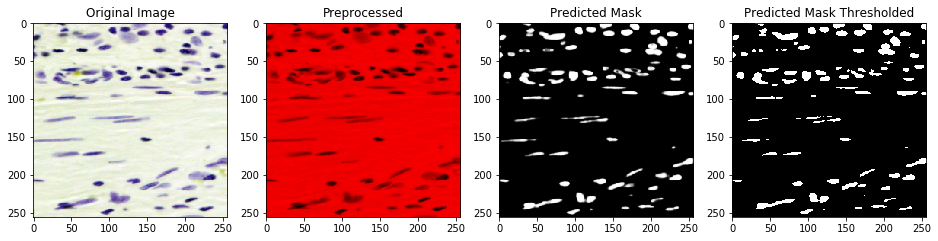

In [ ]:
# Check if test data looks all right
ix = 12# random.randint(0, test_imgs.shape[0]) # 50/57 easy, 42 medium, 7/37/24 hard,  9 bw small, 59 good example bw, 12 many cells in color, 54 many cells bw, 62 messy, 5 monster
print(ix)

fig4 = plt.figure(figsize=(16, 16))
plt.subplot(141).set_title('Original Image')
plt.imshow(test_imgs[ix])
plt.subplot(142).set_title('Preprocessed')
plt.imshow(preproc_test_imgs[ix])
plt.subplot(143).set_title('Predicted Mask')
plt.imshow(np.squeeze(preds_test[ix]), cmap='gray')
plt.subplot(144).set_title('Predicted Mask Thresholded')
plt.imshow(np.squeeze(preds_test_t[ix]), cmap='gray')
plt.show()

This looks very reasonable. 

## 9) Cell counting

Implement a function to count the number of cells within an image.
Here I used a combination of functions from the opencv package.

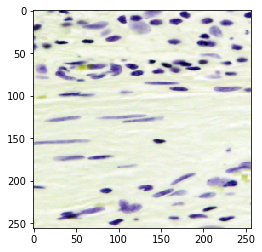

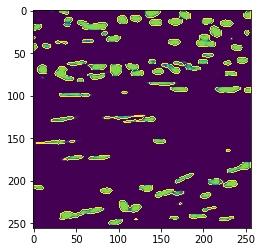

Found 73 cells.
	Size of cell 0: 21
	Size of cell 1: 6
	Size of cell 2: 12
	Size of cell 3: 11
	Size of cell 4: 13
	Size of cell 5: 50
	Size of cell 6: 18
	Size of cell 7: 5
	Size of cell 8: 29
	Size of cell 9: 15
	Size of cell 10: 38
	Size of cell 11: 15
	Size of cell 12: 8
	Size of cell 13: 15
	Size of cell 14: 40
	Size of cell 15: 30
	Size of cell 16: 31
	Size of cell 17: 14
	Size of cell 18: 20
	Size of cell 19: 6
	Size of cell 20: 7
	Size of cell 21: 17
	Size of cell 22: 13
	Size of cell 23: 17
	Size of cell 24: 54
	Size of cell 25: 15
	Size of cell 26: 8
	Size of cell 27: 7
	Size of cell 28: 24
	Size of cell 29: 17
	Size of cell 30: 13
	Size of cell 31: 8
	Size of cell 32: 20
	Size of cell 33: 12
	Size of cell 34: 14
	Size of cell 35: 34
	Size of cell 36: 15
	Size of cell 37: 17
	Size of cell 38: 16
	Size of cell 39: 31
	Size of cell 40: 38
	Size of cell 41: 32
	Size of cell 42: 17
	Size of cell 43: 18
	Size of cell 44: 9
	Size of cell 45: 12
	Size of cell 46: 15
	Size of cell 47

In [ ]:
# Count cells using predicted mask

original_img=test_imgs[ix] #original image
img0 = original_img.copy()
#img0 = np.asarray(original_img)
plt.imshow(img0)
plt.show()

def count_cells(pred_mask, t=65):
    
    img_mask=np.squeeze(pred_mask)
    plt.imsave('test.png', img_mask)

    image = Image.open('test.png').convert("L")
    img = np.asarray(image)
    img = img.copy()
    blur = cv2.GaussianBlur(img, (5, 5), 0)
    (t, binary) = cv2.threshold(blur, t, 255, cv2.THRESH_BINARY)

    # find contours
    (_, contours, _) = cv2.findContours(binary, cv2.RETR_EXTERNAL, 
    cv2.CHAIN_APPROX_SIMPLE)

    # create all-black mask image
    mask = np.zeros(img.shape, dtype="uint8")

    # draw white rectangles for each object's bounding box
    for c in contours:
        (x, y, w, h) = cv2.boundingRect(c)
        cv2.rectangle(mask, (x, y), (x + w, y + h), (255, 255, 255), -1)

    # draw contours over original image
    cv2.drawContours(img, contours, -1, (255, 100, 100), 1)

    plt.imshow(img)
    plt.show()

    # print table of contours and sizes
    print("Found %d cells." % len(contours))
    for (i, c) in enumerate(contours):
        print("\tSize of cell %d: %d" % (i, len(c)))
    return

count_cells(preds_test[ix], t=65)

In [ ]:
## Final thoughts

The final result from this pipeline is a segmented image with cells counted. It works well as a first prototype and proof of concept but there is much room for improvement; for example, some of the cells overlap and get clustered together as one single cell, which also leads to under counting. Future post-processing using water shed techniques should help with this. Additionally, I'd like to try other network architectures including R-CNN.